# 0- Setup

In [1]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
        
        
%load_ext autoreload
%autoreload 2

#magic commands 

- Naming convention:
  - g German dataset 
  - int: Initial dataset without anomalies removal
  - GHF: dataset containing onservables 
  - grid: grid containing observables 


# 1- Importing Libraries 

In [3]:
#Logging and Warnings
import warnings  # Provides a way to handle warning messages that may occur during the execution of the code.
import logging  # Module for flexible logging of messages and errors.


#Visualization
import matplotlib.pyplot as plt  # Plotting library for creating various types of plots and visualizations.
import seaborn as sns  # Library for creating statistical graphics, such as heatmaps and scatterplots.


#File and Path Operations
from pathlib import Path  # Object-oriented filesystem paths.
import joblib  # Module for saving and loading Python objects.
import pickle  # Module for serializing and deserializing Python objects.


#Data Manipulation and Analysis
import pandas as pd  # Data manipulation and analysis library.
import numpy as np  # Fundamental package for scientific computing with Python.


#Machine Learning
from sklearn import (
    compose,  
    model_selection,
)
from skopt import BayesSearchCV  # For hyperparameter optimization using Bayesian search.

from uq360.utils.misc import  make_sklearn_compatible_scorer

from QRF.wrapper.qrf_wrapper import QuantileRegressionForest

import GQ_utils as utils  # Custom module for AFQ utilities.

#Directory and Styling
DIR = Path().resolve()  # Current working directory.
sns.set_theme(style="white")  # Set the default theme/style for Seaborn.

#Logging Configuration and Ignoring Warnings
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Ignore warnings
warnings.filterwarnings('ignore')


# 2- Variables and constants

### Constants relative to datasets

In [4]:
#Initialize a dictionary called obs with different lists as values.
#obs are organized alphabetically
obs_dict = {
'REF_CODE_UNTRANS': {'BG': 'BG',  'CTD_vb35': 'CTD_vb35',  'DEM': 'DEM',  'MAG_CLASS': 'MAG',  'FA': 'FA',  'GEOID_A': 'GEOID_A',  'LAB': 'LAB',  'MOHO': 'MOHO',  'RHO_L': 'RHO_L',  'SEDIMENT': 'SEDIMENT',  'SI': 'SI',  'VOLCS_DIST_W': 'VOLCS_DIST',  'VP': 'VP_VELOCITY',  'VS': 'VS_VELOCITY',  'STRESS_DIST_W': 'STRESS_DIST'},
'LABELS': {'BG': 'Bouguer Anomaly',  'CTD_vb35': 'Curie Depth',  'DEM': 'DEM',  'MAG_CLASS': 'Magnetic Anomaly',  'FA': 'Free Air Anomaly',  'GEOID_A': 'Geoid',  'LAB': 'LAB Depth',  'MOHO': 'Moho Depth',  'RHO_L': 'Litho. ρ',  'SEDIMENT': 'Sediment Thickness',  'SI': 'Shape Index',  'VOLCS_DIST_W': 'Proximity to Volcano',  'VP': 'Δ$P_v$ @150Km tomography',  'VS': 'Δ$S_v$ @150km tomography',  'STRESS_DIST_W': 'Proximity to Faults'},
'LABELS_gmt': {'BG': 'Bouguer\tAnomaly',  'CTD_vb35': 'Curie\tDepth',  'DEM': 'DEM',  'MAG_CLASS': 'Magnetic\tAnomaly',  'FA': 'Free\tair\tanomaly',  'GEOID_A': 'Geoid',  'LAB': 'LAB\tDepth',  'MOHO': 'Moho\tDepth',  'RHO_L': 'Lith.\t@~r@ ',  'SEDIMENT': 'Sediment\tThickness',  'SI': 'Shape\tindex',  'VOLCS_DIST_W': 'Proximity\tto\tvolcano',  'VP': '@~D@~P@_v@\t@@150km\ttomography',  'VS': '@~D@~S@_v@\t@@150km\ttomography',  'STRESS_DIST_W': 'Proximity\tto\tfaults'},
'LABELS_gmt_UNTRANS': {'BG': 'Bouguer\tAnomaly',  'CTD_vb35': 'Curie\tDepth',  'DEM': 'DEM',  'MAG_CLASS': 'Magnetic\tAnomaly',  'FA': 'Free\tair\tAnomaly',  'GEOID_A': 'Geoid',  'LAB': 'LAB\tDepth',  'MOHO': 'Moho\tDepth',  'RHO_L': 'Lith.\t@~r@ ',  'SEDIMENT': 'Sediment\tThickness',  'SI': 'Shape\tindex',  'VOLCS_DIST_W': 'Distance\tto\tVolcano',  'VP': 'P@_v@\t@@150km\ttomography',  'VS': 'S@_v@\t@@150km\ttomography',  'STRESS_DIST_W': 'Distance\tto\tfaults'},
'UNITS': {'BG': 'mGal',  'CTD_vb35': 'km',  'DEM': 'm',  'MAG_CLASS': 'f(nT)',  'FA': 'mGal',  'GEOID_A': 'm',  'LAB': 'km',  'MOHO': 'km',  'RHO_L': 'kgm$^{-3}$',  'SEDIMENT': 'km',  'SI': 'si',  'VOLCS_DIST_W': 'f(Km)',  'VP': '%',  'VS': '%',  'STRESS_DIST_W': 'f(km)'},
'UNITS_gmt': {'BG': 'mGal',  'CTD_vb35': 'km',  'DEM': 'm',  'MAG_CLASS': 'f(nT)',  'FA': 'mGal',  'GEOID_A': 'm',  'LAB': 'km',  'MOHO': 'km',  'RHO_L': 'kgm@+-3@',  'SEDIMENT': 'km',  'SI': 'si',  'VOLCS_DIST_W': 'f(Km)',  'VP': '%',  'VS': '%',  'STRESS_DIST_W': 'f(km)'},
'UNITS_gmt_UNTRANS': {'BG': 'mGal',  'CTD_vb35': 'km',  'DEM': 'm',  'MAG_CLASS': 'nT',  'FA': 'mGal',  'GEOID_A': 'm',  'LAB': 'km',  'MOHO': 'km',  'RHO_L': 'kgm@+-3@',  'SEDIMENT': 'km',  'SI': 'si',  'VOLCS_DIST_W': 'Km',  'VP': 'ms@+-2@',  'VS': 'ms@+-2@',  'STRESS_DIST_W': 'km'},
'V_RANGE_W': {'BG': (-100, 100),  'CTD_vb35': (10, 40),  'DEM': (-2200, 2200),  'MAG_CLASS': (-0.4, 0.4),  'FA': (-100, 100),  'GEOID_A': (-30, 30),  'LAB': (0, 300),  'MOHO': (15, 60),  'RHO_L': (3.26, 3.36),  'SEDIMENT': (0, 10),  'SI': (-1, 1),  'VOLCS_DIST_W': (0, 1),  'VP': (-0.02, 0.02),  'VS': (-0.1, 0.1),  'STRESS_DIST_W': (0, 1)}, 'V_RANGE_G': {'BG': (-100, 100),  'CTD_vb35': (10, 40),  'DEM': (-2200, 2200),  'MAG_CLASS': (-0.4, 0.4),  'FA': (-100, 100),  'GEOID_A': (-30, 30),  'LAB': (50, 250),  'MOHO': (20, 50),  'RHO_L': (3.26, 3.36),  'SEDIMENT': (0, 10),  'SI': (-1, 1),
'VOLCS_DIST_W': (0, 1),  'VP': (8.1, 8.4),  'VS': (4.2, 4.7),  'STRESS_DIST_W': (0, 1)},
'V_RANGE_G_UNTRANS': {'BG': (-100, 100),  'CTD_vb35': (10, 40),  'DEM': (-2200, 2200),  'MAG_CLASS': (-200, 200),  'FA': (-100, 100),  'GEOID_A': (-30, 30),  'LAB': (50, 250),  'MOHO': (20, 50),  'RHO_L': (3.26, 3.36),  'SEDIMENT': (0, 10),  'SI': (-1, 1),  'VOLCS_DIST_W': (0, 300),  'VP': (8.1, 8.4),  'VS': (4.2, 4.7),  'STRESS_DIST_W': (0, 300)},
'CMAPS_gmt': {'BG': 'SCM/vik',  'CTD_vb35': 'SCM/bamako',  'DEM': 'gmt/geo',  'MAG_CLASS': 'SCM/bilbao',  'FA': 'SCM/vik',  'GEOID_A': 'SCM/vik',  'LAB': 'SCM/bamako',  'MOHO': 'SCM/bamako',  'RHO_L': 'SCM/batlow',  'SEDIMENT': 'SCM/davos',  'SI': 'SCM/broc',  'VOLCS_DIST_W': 'SCM/broc',  'VP': 'SCM/roma',  'VS': 'SCM/roma',  'STRESS_DIST_W': 'SCM/broc'},
'LABELS_REDUCED': {'BG': 'Bouguer Anom.',  'CTD_vb35': 'Curie Depth',  'DEM': 'Topography',  'MAG_CLASS': 'Magnetic Anom.',  'FA': 'Free Air Anom.',  'GEOID_A': 'Geoid',
'LAB': 'LAB Depth',  'MOHO': 'Moho Depth',  'RHO_L': 'Litho. ρ',  'SEDIMENT': 'Sediment Thick.',  'SI': 'Shape Index',  'VOLCS_DIST_W': 'Prox. to Volcanos',  'VP': 'P wave tomogr.',  'VS': 'S wave tomogr.',  'STRESS_DIST_W': 'Prox. to Faults'}
}


# Set OBS_REF as index, making it easy to access by referencing observable
obs_df = pd.DataFrame(obs_dict)

# Set OBS_REF as index, making it easy to access by referencing observable
obs_df.sort_values(by='UNITS_gmt', ascending=True)

,REF_CODE_UNTRANS,LABELS,LABELS_gmt,LABELS_gmt_UNTRANS,UNITS,UNITS_gmt,UNITS_gmt_UNTRANS,V_RANGE_W,V_RANGE_G,V_RANGE_G_UNTRANS,CMAPS_gmt,LABELS_REDUCED
VP,VP_VELOCITY,Δ$P_v$ @150Km tomography,@~D@~P@_v@\t@@150km\ttomography,P@_v@\t@@150km\ttomography,%,%,ms@+-2@,"(-0.02, 0.02)","(8.1, 8.4)","(8.1, 8.4)",SCM/roma,P wave tomogr.
VS,VS_VELOCITY,Δ$S_v$ @150km tomography,@~D@~S@_v@\t@@150km\ttomography,S@_v@\t@@150km\ttomography,%,%,ms@+-2@,"(-0.1, 0.1)","(4.2, 4.7)","(4.2, 4.7)",SCM/roma,S wave tomogr.
VOLCS_DIST_W,VOLCS_DIST,Proximity to Volcano,Proximity\tto\tvolcano,Distance\tto\tVolcano,f(Km),f(Km),Km,"(0, 1)","(0, 1)","(0, 300)",SCM/broc,Prox. to Volcanos
STRESS_DIST_W,STRESS_DIST,Proximity to Faults,Proximity\tto\tfaults,Distance\tto\tfaults,f(km),f(km),km,"(0, 1)","(0, 1)","(0, 300)",SCM/broc,Prox. to Faults
MAG_CLASS,MAG,Magnetic Anomaly,Magnetic\tAnomaly,Magnetic\tAnomaly,f(nT),f(nT),nT,"(-0.4, 0.4)","(-0.4, 0.4)","(-200, 200)",SCM/bilbao,Magnetic Anom.
RHO_L,RHO_L,Litho. ρ,Lith.\t@~r@,Lith.\t@~r@,kgm$^{-3}$,kgm@+-3@,kgm@+-3@,"(3.26, 3.36)","(3.26, 3.36)","(3.26, 3.36)",SCM/batlow,Litho. ρ
CTD_vb35,CTD_vb35,Curie Depth,Curie\tDepth,Curie\tDepth,km,km,km,"(10, 40)","(10, 40)","(10, 40)",SCM/bamako,Curie Depth
LAB,LAB,LAB Depth,LAB\tDepth,LAB\tDepth,km,km,km,"(0, 300)","(50, 250)","(50, 250)",SCM/bamako,LAB Depth
MOHO,MOHO,Moho Depth,Moho\tDepth,Moho\tDepth,km,km,km,"(15, 60)","(20, 50)","(20, 50)",SCM/bamako,Moho Depth
SEDIMENT,SEDIMENT,Sediment Thickness,Sediment\tThickness,Sediment\tThickness,km,km,km,"(0, 10)","(0, 10)","(0, 10)",SCM/davos,Sediment Thick.


In [5]:
# Read CSV file and convert columns to appropriate data types
ghf_f = DIR / 'Dataset' / 'Preprocessed' / f'ghf_6_int.csv' 
ghf_df = pd.read_csv(ghf_f, sep='\t')

# Set variable values
TARGET       = 'GHF'
TARGET_LABEL = 'Heat Flow'
COORDs       = ['lon', 'lat']
GRID_INDEX_G = 'grid_index'
GHF_BOUNDS   = (int(ghf_df[TARGET].min()), int(np.ceil(ghf_df[TARGET].max())))
                

# Create full header names with short labels of observables for World and Germany
observables_lst   = obs_df.index.tolist()
observables_g_lst = observables_lst + COORDs + [GRID_INDEX_G, TARGET]

# Create header names with short labels of observables
observables_ghf_lst = observables_lst + [TARGET]

# Create full header names with long labels of observables for World and germnay
labels_lst   = obs_df.loc[observables_lst, 'LABELS_REDUCED'].values.tolist()
labels_g_lst = labels_lst + ['lon', 'lat', GRID_INDEX_G, TARGET]

# Create header names with long labels of observables
labels_ghf_lst = labels_lst + [TARGET_LABEL]



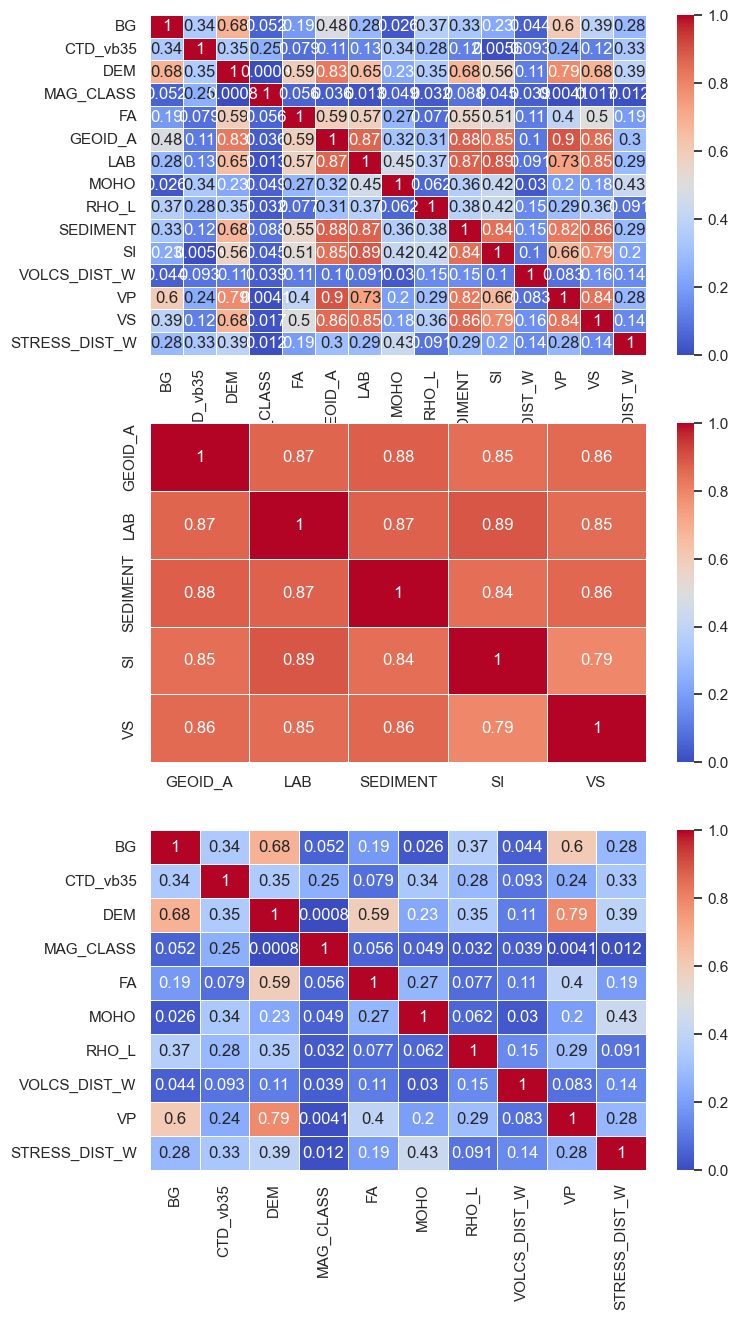

In [6]:
def remove_highly_correlated_features(df, threshold=0.8):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)] 
    #to_drop.remove('LAB')
    to_drop.remove('VP')
    df_reduced = df.drop(columns=to_drop)
    return df_reduced, to_drop

# Assuming df is your DataFrame containing the features
ghf_non_cor_df, to_drop = remove_highly_correlated_features(ghf_df[observables_lst], threshold=0.8)

correlation_matrix = ghf_df[observables_lst].corr().abs()
correlation_matrix_keep = ghf_non_cor_df.corr().abs()
correlation_matrix_drop= ghf_df[to_drop].corr().abs()


fig, axes = plt.subplots(3,1, figsize=(8, 15))
sns.heatmap(correlation_matrix, ax=axes[0], annot=True, vmin=0, vmax=1, cmap='coolwarm', linewidths=0.5)
sns.heatmap(correlation_matrix_drop, ax=axes[1], annot=True, vmin=0, vmax=1, cmap='coolwarm', linewidths=0.5)
sns.heatmap(correlation_matrix_keep, ax=axes[2], annot=True, vmin=0, vmax=1, cmap='coolwarm', linewidths=0.5)


plt.show()

In [7]:
obs_df = obs_df.drop(labels=to_drop)

# Create full header names with short labels of observables for World and Germany
observables_lst   = obs_df.index.tolist()
observables_g_lst = observables_lst + COORDs + [GRID_INDEX_G, TARGET]

# Create header names with short labels of observables
observables_ghf_lst = observables_lst + [TARGET]

# Create full header names with long labels of observables for World and Germany
labels_lst   = obs_df.loc[observables_lst, 'LABELS'].values.tolist()
labels_g_lst = labels_lst + ['lon', 'lat', GRID_INDEX_G, TARGET]

# Create header names with long labels of observables
labels_ghf_lst = labels_lst + [TARGET_LABEL]

In [8]:
# Separate features from target variable
X = ghf_df[observables_lst].values
y = ghf_df[TARGET].values.ravel()
weights = ghf_df['normalized_weights'].values


# 3. Determining the hyperparameter serach space

n_estimators: the number of trees in the forest. A higher number of trees can improve the performance of the model, but also increase the computation time. A good starting range could be between 100 and 1000, depending on the size of your dataset.

max_depth: the maximum depth of each decision tree. A deeper tree can capture more complex relationships in the data, but may also overfit the data. A good starting range could be between 5 and 30, depending on the number of features and the size of your dataset.

max_features: the maximum number of features to consider when looking for the best split. A lower number can reduce overfitting, but may also result in a less accurate model. A good starting range could be between 0.1 and 1.0, depending on the number of features in your dataset.

min_samples_leaf: the minimum number of samples required to be at a leaf node. A higher number can reduce overfitting, but may also result in a less accurate model. A good starting range could be between 1 and 10, depending on the size of your dataset.

min_samples_split: the minimum number of samples required to split an internal node. A higher number can reduce overfitting, but may also result in a less accurate model. A good starting range could be between 2 and 20, depending on the size of your dataset.

In [9]:
# Set hyperparameters
KFOLD = 5
N_ITER = 100
RANDOM_STATE = 42
N_JOBS = 1
VERBOSE = 4

config_bl = { 'n_estimators' : 1000, "bootstrap": True, "criterion": "squared_error", "random_state": RANDOM_STATE,}

classes  = {
    "class_min" : GHF_BOUNDS[0], 
    "class_max" : GHF_BOUNDS[1], 
}

split_base = int(X.shape[0]* 0.01) * 2
leaf_base  = int(X.shape[0]* 0.01)
depth_base = int(np.log2(X.shape[0]))
                 

search_spaces_dict = {    
    'n_estimators' :np.arange(800, 1400, 50),
    "max_depth": list(range(3, depth_base+10, 1)),  # Additional depths including None for unlimited
    "min_samples_split": list(range(split_base-4, split_base+6, 1)),  # From 2 to 10 in steps of 2
    "min_samples_leaf": list(range(leaf_base-2, leaf_base+3)),  # From 1 to 4
    "max_samples": list(np.arange(0.6, 0.9, 0.1)),  # Extended range of fractions
    "max_features": list(np.arange(0.6, 0.9, 0.1)),  # Including 'auto', 'sqrt', 'log2'
    #"bootstrap": [True, False],
    #"max_leaf_nodes": [None, 5, 10, 15, 20, 30, 40],  # Grow trees with max_leaf_nodes in best-first fashion
    #"criterion": ['squared_error', 'absolute_error'],  # Measure the quality of a split
    #"min_weight_fraction_leaf": list(np.arange(0.0, 0.2, 0.01)),  # Minimum weighted fraction of the sum total of weights required to be at a leaf node
    #"min_impurity_decrease": [0.0, 0.1, 0.2, 0.3],  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    #"ccp_alpha": [0.0, 0.01, 0.1]  # Complexity parameter used for Minimal Cost-Complexity Pruning.
}




### Analysis of the effect of all hyperparameter together

In [10]:


cv_fnct = model_selection.KFold(n_splits=KFOLD, random_state=RANDOM_STATE, shuffle=True)
qrt = QuantileRegressionForest(**classes).set_params(**config_bl)



scoring_fnct = make_sklearn_compatible_scorer(task_type="regression", 
                                            metric="picp", greater_is_better=True)


###BEYSIANSEARCH

# Initialize BaysSearch object   
bayes_search = BayesSearchCV(
        estimator=qrt,
        search_spaces=search_spaces_dict,
        n_iter=N_ITER,
        return_train_score=False,
        random_state=RANDOM_STATE,
        scoring=scoring_fnct,
        cv=cv_fnct,
        verbose=VERBOSE,
        n_jobs=N_JOBS,   
        #optimizer_kwargs=None,
        #fit_params=False,
        #n_points=5,
        refit=False,
        #pre_dispatch='2*n_jobs',
        #error_score=1
)


# Print message to user
logging.info(f"Now tuning.")

# Fit BAYESIAN_CV
bayes_search.fit(X, y, sample_weight=weights) 
#bayes_search.fit(X, y) 


# Get best parameters and score
best_params_dict = bayes_search.best_params_
best_score       = bayes_search.best_score_

logging.info(f"Best score: {best_score}")
logging.info(best_params_dict)


logging.info('terminated')



2024-08-14 23:15:37,212 - INFO - Now tuning.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


Estimating for samples: 100%|██████████████████████████████████████████████████████| 119/119 [00:00<00:00, 4807.34it/s]
2024-08-14 23:15:40,078 - INFO - Calculating Quantiles has been terminated


[CV 1/5] END max_depth=9, max_features=0.7999999999999999, max_samples=0.8999999999999999, min_samples_leaf=4, min_samples_split=12, n_estimators=1000;, score=0.370 total time=   2.7s


KeyboardInterrupt: 

In [ ]:
results = pd.DataFrame(bayes_search.cv_results_)
    
# Plotting the results
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

axs[0, 0].scatter(results['param_n_estimators'], results['mean_test_score'])
axs[0, 0].set_xlabel('n_estimators')
axs[0, 0].set_ylabel('Mean CV Accuracy')
axs[0, 0].set_title('n_estimators vs Mean CV Accuracy')

axs[0, 1].scatter(results['param_max_depth'], results['mean_test_score'])
axs[0, 1].set_xlabel('max_depth')
axs[0, 1].set_ylabel('Mean CV Accuracy')
axs[0, 1].set_title('max_depth vs Mean CV Accuracy')


axs[1, 0].scatter(results['param_min_samples_split'], results['mean_test_score'])
axs[1, 0].set_xlabel('min_samples_split')
axs[1, 0].set_ylabel('Mean CV Accuracy')
axs[1, 0].set_title('min_samples_split vs Mean CV Accuracy')


axs[1, 1].scatter(results['param_min_samples_leaf'], results['mean_test_score'])
axs[1, 1].set_xlabel('min_samples_leaf')
axs[1, 1].set_ylabel('Mean CV Accuracy')
axs[1, 1].set_title('min_samples_leaf vs Mean CV Accuracy')


axs[2, 0].scatter(results['param_max_samples'], results['mean_test_score'])
axs[2, 0].set_xlabel('max_samples')
axs[2, 0].set_ylabel('Mean CV Accuracy')
axs[2, 0].set_title('max_samples vs Mean CV Accuracy')

axs[2, 1].scatter(results['param_max_features'], results['mean_test_score'])
axs[2, 1].set_xlabel('max_features')
axs[2, 1].set_ylabel('Mean CV Accuracy')
axs[2, 1].set_title('max_features vs Mean CV Accuracy')


plt.tight_layout()
plt.show()


In [ ]:
utils.table_grid_search(bayes_search, all_ranks=True)

### saving grid search and hyperparameters

In [ ]:
# Define file paths
best_params_path = DIR / 'Hyperparameters' / 'hyperparameters.pkl'
grid_results_path = DIR / 'Hyperparameters' / 'tuned_grid.csv'

dropped_columns = ['mean_fit_time', 'std_fit_time', 'params', 'mean_score_time', 'std_score_time']

# Saving the dictionary using pickle
with open(best_params_path, 'wb') as f:
    pickle.dump(best_params_dict, f)


# Save grid search results to file
bayes_search_df = pd.DataFrame(bayes_search.cv_results_)
bayes_search_df = bayes_search_df.drop(columns=dropped_columns)
bayes_search_df = bayes_search_df.sort_values('rank_test_score', ascending=True).reset_index(drop=True)
#flip sign

bayes_search_df.to_csv(grid_results_path, index=False, sep='\t')